In [1]:
import pandas as pd
import nltk
import re
import praw

In [ ]:
import praw
import pandas as pd

reddit = praw.Reddit(
    client_id = '6DqeMkrmoM0HZXoL_weubQ',
    client_secret = 'Zp-UQaaxMSScK8tyV92TNPeG_tpdjg',
    user_agent = 'praw'
)
def getComments(id):
    submission = reddit.submission(id)
    pandas_list = []
    commentsList = submission.comments.list()
    submission.comments.replace_more(limit=64)
    print(len(commentsList))
    i = 0
    for c in commentsList:
        if isinstance(c, praw.models.MoreComments):
            continue
        commentText = c.body
        if commentText in {'[deleted]', '[removed]'}:
            continue
        pandas_list.append([i, commentText])
        i+=1
    df = pd.DataFrame(pandas_list)
    df.columns = ['id', 'description']
    return df

In [3]:
corpus = getComments('1detli')

print(corpus.shape)
corpus.head()

902
(452, 2)


,id,description
0,0,My father passed away last year. One item he ...
1,1,My mom told me this story the other day and it...
2,2,"When I was 15, my mother and I were standing i..."
3,3,Scariest moment of my life happened while my f...
4,4,I saw a 'shadow person' once.\n\nI didn't know...


In [4]:
print('First spooky story : ',corpus.loc[0,'description'])

First spooky story :  My father passed away last year.  One item he always said he wanted me to have was a shotgun which had originally belonged to his grandfather.  For years he had this shotgun stashed in the attic.  After he passed, I had gone in the attic to look for it, only to find that it wasn't there.

A few months later, I had a dream in which I was talking to him and I asked him where he had put the shotgun.  He told me it was in the closet of a spare bedroom.  I called my mother and had her check, and sure enough that's where it was.

Now it's completely possible that my father had told me that when he was alive, and the dream was little more than a memory, but I certainly don't recall that being the case.


In [ ]:
corpus['clean_description'] = corpus['description'].str.replace(r'<.*?>', '', regex=True)
corpus['clean_description'] = corpus['clean_description'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

corpus['clean_description'] = corpus['clean_description'].str.lower()

nltk.download('punkt', quiet=True)
corpus['clean_tokens'] = corpus['clean_description'].apply(nltk.word_tokenize)

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag

nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return 'a'
    elif treebank_tag.startswith('V'): return 'v'
    elif treebank_tag.startswith('N'): return 'n'
    elif treebank_tag.startswith('R'): return 'r'
    else: return 'n'

def lemmatize_tokens(tokens):
    lemmatized = []
    tagged_tokens = pos_tag(tokens)
    for word, tag in tagged_tokens:
        if word not in stop_words:
            wn_tag = get_wordnet_pos(tag)
            lemmatized.append(lemmatizer.lemmatize(word, wn_tag))
    return lemmatized

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lemmatize_tokens)

corpus['clean_document'] = corpus['clean_tokens'].apply(lambda tokens: ' '.join(tokens))

print("DataFrame після повної обробки:")
print(corpus.head())
print("-" * 20)

DataFrame після повної обробки:
   id                                        description  \
0   0  My father passed away last year.  One item he ...   
1   1  My mom told me this story the other day and it...   
2   2  When I was 15, my mother and I were standing i...   
3   3  Scariest moment of my life happened while my f...   
4   4  I saw a 'shadow person' once.\n\nI didn't know...   

                                   clean_description  \
0  my father passed away last year  one item he a...   
1  my mom told me this story the other day and it...   
2  when i was  my mother and i were standing in t...   
3  scariest moment of my life happened while my f...   
4  i saw a shadow person once\n\ni didnt know tha...   

                                        clean_tokens  \
0  [father, pass, away, last, year, one, item, al...   
1  [mom, tell, story, day, freak, fuck, old, sist...   
2  [mother, stand, kitchen, talk, rack, wall, hol...   
3  [scary, moment, life, happen, friend, camp,

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

svd_model = TruncatedSVD(n_components=2, random_state=42)
lsa_matrix = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa_matrix, columns=["topic_" + str(i) for i in range(2)])
topic_encoded_df["documents"] = corpus['clean_description']

def extract_main_topic(topic_scores):
    return topic_scores.idxmax()

topic_encoded_df['main_topic'] = topic_encoded_df.iloc[:, :-1].apply(extract_main_topic, axis=1)

print("Документи з визначеними головними темами:")
print(topic_encoded_df.head())
print("-" * 20)


terms = vectorizer.get_feature_names_out()
topics_description = pd.DataFrame(svd_model.components_, columns=terms)

print("Найважливіші слова для кожної теми:")
for i, topic in enumerate(topics_description.values):
    top_word_indices = topic.argsort()[-5:][::-1]
    top_words = [terms[j] for j in top_word_indices]
    print(f"Тема {i}: {', '.join(top_words)}")

Документи з визначеними головними темами:
    topic_0   topic_1                                          documents  \
0  0.202900 -0.049542  my father passed away last year  one item he a...   
1  0.252138 -0.045123  my mom told me this story the other day and it...   
2  0.179119 -0.014688  when i was  my mother and i were standing in t...   
3  0.280425 -0.044360  scariest moment of my life happened while my f...   
4  0.385310  0.005832  i saw a shadow person once\n\ni didnt know tha...   

  main_topic  
0    topic_0  
1    topic_0  
2    topic_0  
3    topic_0  
4    topic_0  
--------------------
Найважливіші слова для кожної теми:
Тема 0: like, time, say, house, tell
Тема 1: ghost, nice, thats, mean, asshole


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(corpus['clean_tokens'])]

d2v_model = Doc2Vec(tagged_data, vector_size=50, window=5, min_count=1, workers=4, epochs=40)

doc_vector = d2v_model.dv[0]
print("\n--- Завдання 1: Doc2Vec ---")
print(f"Розмірність вектору документа, отриманого з Doc2Vec: {doc_vector.shape}")

similar_docs = d2v_model.dv.most_similar([doc_vector])
print(f"Документи, найбільш схожі на перший: {similar_docs}")


--- Завдання 1: Doc2Vec ---
Розмірність вектору документа, отриманого з Doc2Vec: (50,)
Документи, найбільш схожі на перший: [(0, 1.0), (47, 0.960698664188385), (9, 0.950233519077301), (37, 0.945475161075592), (7, 0.9394036531448364), (276, 0.9349154829978943), (245, 0.9332249760627747), (92, 0.93051677942276), (278, 0.9163379073143005), (172, 0.9125581383705139)]



--- Завдання 2: t-SNE Візуалізація ---


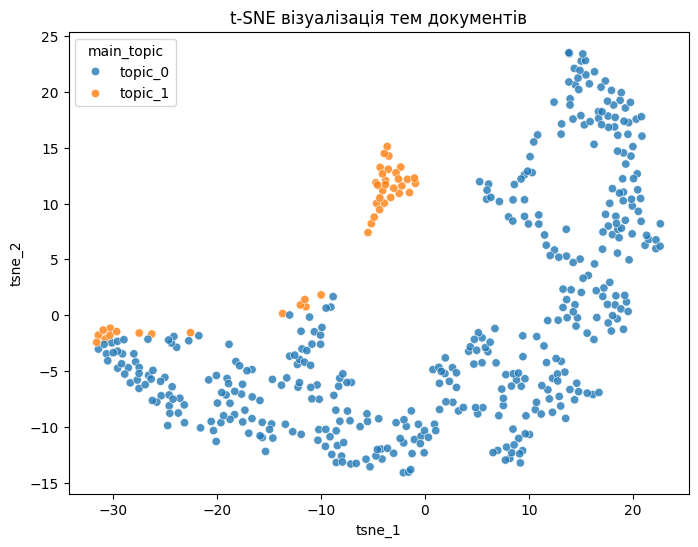

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Завдання 2: t-SNE Візуалізація ---")

tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(lsa_matrix)-1, 30))
tsne_results = tsne.fit_transform(lsa_matrix)

vis_df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
vis_df['main_topic'] = topic_encoded_df['main_topic']

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="main_topic",
    data=vis_df,
    legend="full",
    alpha=0.8
)
plt.title("t-SNE візуалізація тем документів")
plt.show()